In [1]:
import numpy as np
import cv2
from colorthief import ColorThief
import io
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
test_images = ['/Users/Rabbit/Downloads/china_test.jpg', 
               '/Users/Rabbit/Downloads/vilnius_test.jpg', 
               '/Users/Rabbit/Downloads/spices_test.jpg']

In [3]:
loc_fashion_images = ['/Users/Rabbit/capstone/materials/scrape_fashion_2/2003.86.1.png', 
                     '/Users/Rabbit/capstone/materials/scrape_fashion_2/2006.44.1.png', 
                     '/Users/Rabbit/capstone/materials/scrape_fashion_2/2006.56.1.png', 
                     '/Users/Rabbit/capstone/materials/scrape_fashion_2/2006.56.2.png', 
                     '/Users/Rabbit/capstone/materials/scrape_fashion_2/2007.30.1.png', 
                     '/Users/Rabbit/capstone/materials/scrape_fashion_2/2008.4.1.png', 
                     '/Users/Rabbit/capstone/materials/scrape_fashion_2/2010.98.1.png', 
                     '/Users/Rabbit/capstone/materials/scrape_fashion_2/74.32.4.png', 
                     '/Users/Rabbit/capstone/materials/scrape_fashion_2/76.64.1.png', 
                     '/Users/Rabbit/capstone/materials/scrape_fashion_2/80.1.4.png']

In [4]:
# image_path = loc_fashion_images[1]

In [5]:
# !ls ../../dyanye_clothing_era_classifier/

In [6]:
# img = cv2.imread('/Users/Rabbit/Downloads/china_test.jpg')
# img.shape

In [7]:
# Z = img.reshape((-1, 3))

# # convert to np.float32
# Z = np.float32(Z)

# # define criteria, number of clusters(K) and apply kmeans()
# criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
# K = 7
# ret, label, center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

In [8]:
# # Now convert back into uint8, and make original image
# center = np.uint8(center)
# res = center[label.flatten()]
# res2 = res.reshape((img.shape))

# # cv2.imshow('res2',res2)
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()

In [9]:
# center

In [10]:
# img_path = loc_fashion_images[1]

In [11]:
img_path = test_images[1]

In [12]:
# colorthief = ColorThief(pic_test)

#     def get_color_array(self):
# #         """"""
# #         color_arr = convert_rgb_to_percent(self.img_palette)
# #         return color_arr


# #     def convert_rgb_to_percent(img_palette):
# #         """"""
#         for color in img_palette:
#             for rgb_val in color:
#                 color_val.append(rgb_val/255)
#             color_arr.append(tuple(color_val))
#             color_val.clear()
#         return color_arr



In [154]:
class Palettization():
    """processes a single image path and returns image, centroids(dominant colors), palette"""
    
    def __init__(self, img_path):
        self.img_path = img_path
        self.img_palette = self.get_palette_()
        self.color_arr = self.get_color_array()
        self.centroid_lst = self.arrayify_centroids()
        self.counts = self.centroid_cos_similar()

    def get_palette_(self):
        """return image color palette"""
        colorthief = ColorThief(self.img_path)
        img_palette = colorthief.get_palette(color_count=7, quality=1)
        return img_palette


    def get_color_array(self):
        """return array of palette colors"""
        color_arr = []
        for color in self.img_palette:
            color_val = []
            for rgb_val in color:
                color_val.append(rgb_val/255)
            color_arr.append(tuple(color_val))
        return color_arr


    def arrayify_centroids(self):
        """return array of image palette (centroids)"""
        self.centroid_lst = np.array(self.img_palette)
        return self.centroid_lst
    
    def _centroid_cos_similar(self, pixels, centroid):
        numerator = (pixels * centroid).sum(axis=1)
        denominator = (np.linalg.norm(pixels, axis=1) * np.linalg.norm(centroid))
        return (numerator / denominator)  


    def centroid_cos_similar(self):
        """"""
        lst = []
        self.centroid_lst = self.img_palette
        img = cv2.imread(self.img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        for centroid in self.centroid_lst:
            lst.append(self._centroid_cos_similar(img.reshape(-1, 3), centroid))

        centroid_argmax = np.array(lst).argmax(axis=0)

        _, counts = np.unique(centroid_argmax, return_counts=True)
        return counts

    
    def zip_centroid_count(self):
        """"""
        return [{'rgb': rgb, 'count':count} for rgb, count in zip(self.img_palette, self.counts)]
    
    
    def display_palette(self):
        """"""
        self.get_color_array()
        return plt.imshow([(self.color_arr)])

    
    def display_img(self):
        """"""
        colorthief = ColorThief(self.img_path)
        img = colorthief.image
        return img

In [155]:
palette_me_now = Palettization(img_path)

In [156]:
palette_me_now.zip_centroid_count()

[{'count': 266171, 'rgb': (200, 161, 70)},
 {'count': 239798, 'rgb': (36, 46, 40)},
 {'count': 51464, 'rgb': (130, 146, 146)},
 {'count': 13455, 'rgb': (171, 176, 172)},
 {'count': 90169, 'rgb': (123, 145, 125)},
 {'count': 18908, 'rgb': (109, 112, 101)},
 {'count': 16698, 'rgb': (62, 85, 101)}]

In [131]:
try_me = [Palettization(link) for link in test_images]

/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


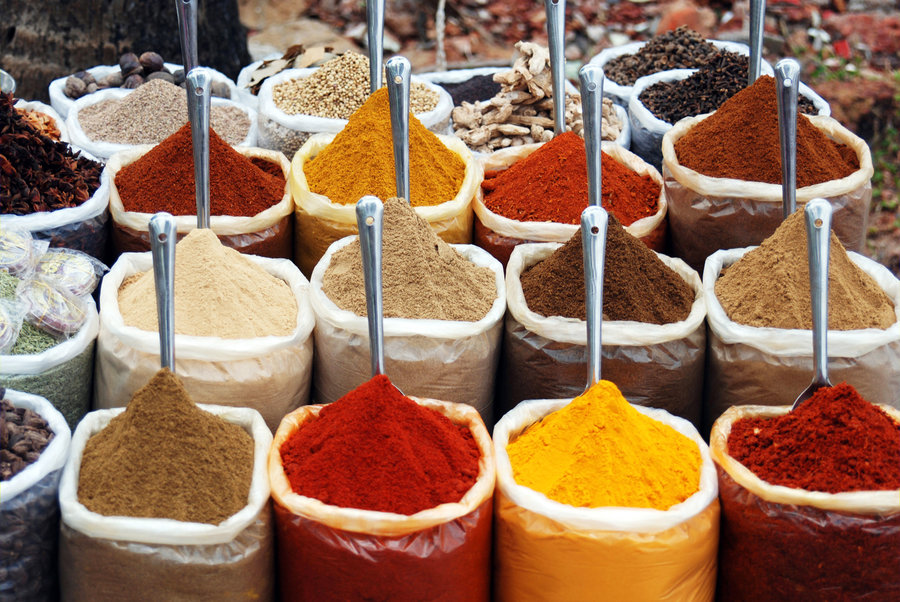

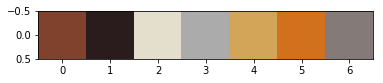

In [157]:
i = 2
try_me[i].display_palette()
try_me[i].display_img()

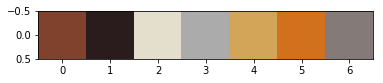

In [133]:
for item in try_me:
    item.display_palette()

In [159]:
try_me[0].arrayify_centroids()

array([[156,  14,  12],
       [152, 173, 201],
       [ 33,  13,  12],
       [170,  83,  69],
       [228, 228, 236],
       [145, 130, 127],
       [148,  98, 110]])

In [68]:
get_palette(img_path)

[(200, 161, 70),
 (36, 46, 40),
 (130, 146, 146),
 (171, 176, 172),
 (123, 145, 125),
 (109, 112, 101),
 (62, 85, 101)]

In [69]:
display_palette()

TypeError: display_palette() missing 1 required positional argument: 'color_arr'

In [34]:
display_palette(color_arr)

NameError: name 'color_arr' is not defined

In [33]:
display_img(img_path)

NameError: name 'colorthief' is not defined

In [ ]:
color_arr

In [ ]:
# lst = []

# for centroid in centroid_lst:
#     lst.append(centroid_cos_similar(img.reshape(-1, 3), centroid))
    
# centroid_argmax = np.array(lst).argmax(axis=0)

# cos_sim_test = np.unique(centroid_argmax, return_counts=True)
# cos_sim_test

In [ ]:
centroid_lst

In [ ]:
plt.imshow([(centroid_lst).astype('uint8')])

In [ ]:

# get_palette(pic_test)
# array_centroids(pic_test)

In [ ]:
# lst = []
# for centroid in centroid_lst:
#     lst.append(centroid_cos_similar(img.reshape(-1, 3), centroid))

In [ ]:
# centroid_argmax = np.array(lst).argmax(axis=0)

In [ ]:
# cos_sim_test = np.unique(centroid_argmax, return_counts=True)
# cos_sim_test

In [ ]:
# import numpy as np

# def centroid_euclidean_dist(pixels, centroid):
#     dist = np.linalg.norm(pixels - centroid, axis=1)
# #     (np.linalg.norm(pixels, axis=1) * np.linalg.norm(centroid))
#     return dist

In [ ]:
# lst = []
# for centroid in centroid_lst:
#     lst.append(centroid_euclidean_dist(img.reshape(-1, 3), centroid))

In [ ]:
# lst

In [ ]:
# centroid_argmin = np.array(lst).argmin(axis=0)

In [ ]:
# np.unique(centroid_argmin, return_counts=True)

In [ ]:
# centroid_dict

In [ ]:
# plt.imshow([(centroid_lst[]).astype('uint8')])

In [ ]:
# import colorgram

# img = ('/Users/Rabbit/capstone/materials/scrape_fashion_2/76.64.1.png')

In [ ]:
# colors = colorgram.extract(img, 6)

In [ ]:
# colors[0]